In [1]:
import tensorflow
import keras as K



print("TensorFlow version:", tensorflow.__version__)
print("Keras version:", K.__version__)

from keras import backend as be
from keras.models import Sequential
from keras.layers import Input , Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, PReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array, array_to_img
from keras.applications import VGG16, InceptionV3, DenseNet201, ResNet50, MobileNetV2
from keras.applications.vgg16 import preprocess_input
from keras import layers, models, regularizers
from keras.preprocessing import image
from keras.optimizers import RMSprop

from tqdm import tqdm
from pyswarm import pso


import pandas as pd
import numpy as np
import random as ra
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
print("opencv-python version:", cv2.__version__)


from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from skimage.util import random_noise

TensorFlow version: 2.13.0
Keras version: 2.13.1
opencv-python version: 4.11.0


In [2]:
 # Parameters
IMG_DIR = "cop_img_dataset1"            # folder where images are stored
CSV_FILE = "cop_img_dataset1/labels.csv"       # your CSV file
IMG_SIZE = (100)         # resize all images
# Load CSV file
df = pd.read_csv(CSV_FILE)  
print(df.head())

                 filename  fill_percentage
0  strip_bottle_0000.jpeg         0.369149
1  strip_bottle_0001.jpeg         0.174511
2  strip_bottle_0002.jpeg         0.126045
3  strip_bottle_0003.jpeg         0.251274
4  strip_bottle_0004.jpeg         0.310335


In [ ]:
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')

noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']
X=[]
X.clear()
Y=[]
Y.clear()
image_files = [img for img in os.listdir(IMG_DIR) if img.lower().endswith(valid_extensions)]
i=0
for img in tqdm(image_files, desc="Processing images"):
    path = os.path.join(IMG_DIR, img)
    noise_type = ra.randint(0, len(noise_modes)-1) 
    GrayImgArray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    if GrayImgArray is None:
        print(f"Skipping invalid or unreadable file: {img}")
        continue
    # Normalize image to [0, 1] before adding noise
    GrayImgArray = GrayImgArray / 255.0
    # Add noise to the image  
    mode = noise_modes[noise_type]

    if mode in ['salt', 'pepper', 's&p']:
        noisy_img = random_noise(GrayImgArray, mode=mode, amount=0.09)
    elif mode == 'gaussian':
        noisy_img = random_noise(GrayImgArray, mode=mode, var=0.003)
    else:
        noisy_img = random_noise(GrayImgArray, mode=mode)

    ReGIA = cv2.resize(noisy_img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(ReGIA, cmap='gray')
    plt.title("Resized Grayscale Image")
    plt.show()
    if i < 9:
        print(f"Image {i+1}: {img}")
        print(f"Noise type: {mode}")
        print(f"Image shape: {ReGIA.shape}")
        i += 1
    else:
        break
    
    X.append(ReGIA)

Y=df.iloc[:, 1] 
X = np.array(X)
print(len(X))
print(X.shape)
print(Y.head())
print(len(Y))
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


CSV loaded:
                 filename  fill_percentage
0  strip_bottle_0000.jpeg         0.369149
1  strip_bottle_0001.jpeg         0.174511
2  strip_bottle_0002.jpeg         0.126045
3  strip_bottle_0003.jpeg         0.251274
4  strip_bottle_0004.jpeg         0.310335
Found 6576 valid images.


Processing images:   0%|          | 0/6576 [00:00<?, ?it/s]

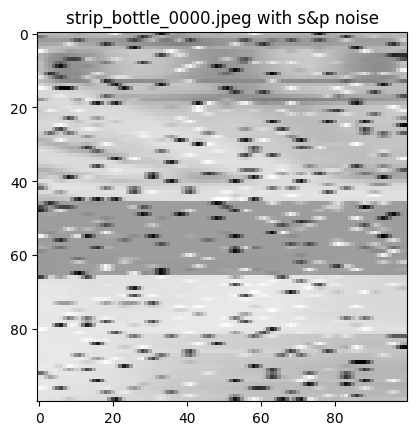

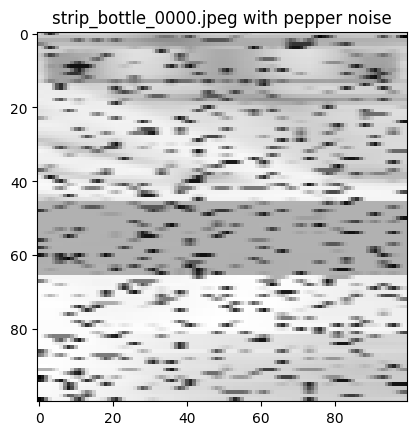

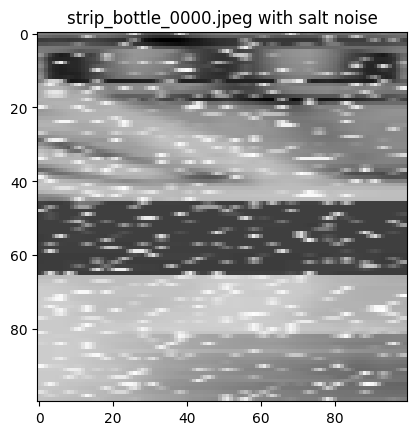

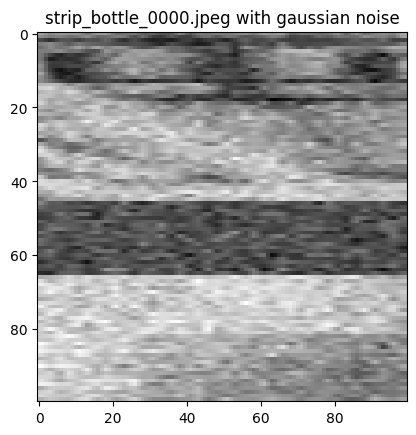

Processing images:   0%|          | 1/6576 [00:02<4:51:09,  2.66s/it]

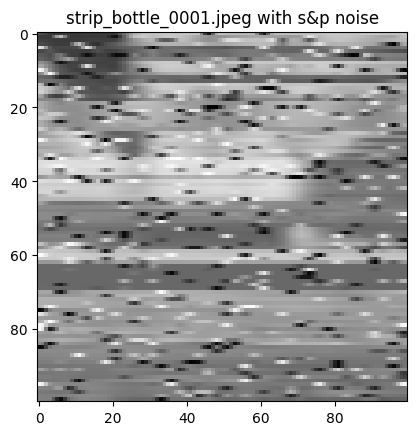

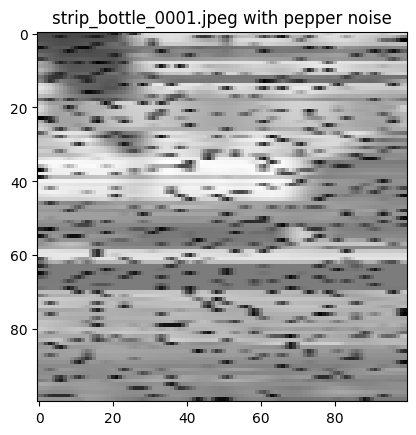

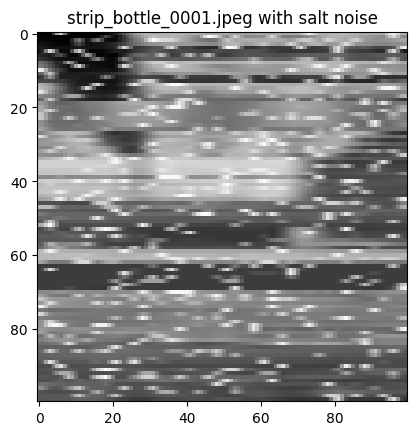

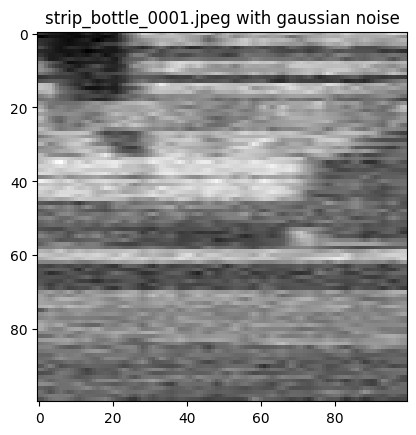

Processing images: 100%|██████████| 6576/6576 [05:42<00:00, 19.20it/s]



Before shuffling:
X shape: (26304, 100, 100)
Y shape: (26304,)

After shuffling:
X shape: (26304, 100, 100)
Y shape: (26304,)

Train set: (19728, 100, 100) (19728,)
Test set: (6576, 100, 100) (6576,)


In [3]:
import os
import random as ra
import numpy as np
import pandas as pd
import cv2
from skimage.util import random_noise
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# --- Configurations ---
# IMG_DIR = 'path_to_your_image_folder'  # <<< Change this to your image folder path
# CSV_PATH = 'path_to_your_csv_file.csv'  # <<< Change this to your CSV file path
# IMG_SIZE = 128  # <<< Target size (change as needed)

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif')
noise_modes = ['s&p', 'pepper', 'salt', 'gaussian']

# --- Load CSV ---
df = pd.read_csv(CSV_FILE)

# Map filename to fill_percentage (label)
labels_dict = dict(zip(df['filename'], df['fill_percentage']))

print("CSV loaded:")
print(df.head())

# --- Prepare Dataset ---
X = []
Y = []

# Get list of valid image files
image_files = [img for img in os.listdir(IMG_DIR) if img.lower().endswith(valid_extensions)]

print(f"Found {len(image_files)} valid images.")

# Augmentation: Apply all 4 noise types to each image
for img in tqdm(image_files, desc="Processing images"):
    path = os.path.join(IMG_DIR, img)
    GrayImgArray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    if GrayImgArray is None:
        print(f"Skipping invalid or unreadable file: {img}")
        continue

    GrayImgArray = GrayImgArray / 255.0  # Normalize to [0, 1]

    for mode in noise_modes:
        # Apply noise based on mode
        if mode in ['salt', 'pepper', 's&p']:
            noisy_img = random_noise(GrayImgArray, mode=mode, amount=0.09)
        elif mode == 'gaussian':
            noisy_img = random_noise(GrayImgArray, mode=mode, var=0.003)
        else:
            noisy_img = random_noise(GrayImgArray, mode=mode)

        # Resize to (IMG_SIZE, IMG_SIZE)
        ReGIA = cv2.resize(noisy_img, (IMG_SIZE, IMG_SIZE))

        # Optional: show first 2 images for confirmation
        if len(X) < 8:
            plt.imshow(ReGIA, cmap='gray')
            plt.title(f"{img} with {mode} noise")
            plt.show()

        X.append(ReGIA)
        Y.append(labels_dict[img])  # Append corresponding fill percentage label

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

print("\nBefore shuffling:")
print("X shape:", X.shape)  # Should be (num_images * 4, IMG_SIZE, IMG_SIZE)
print("Y shape:", Y.shape)

# Shuffle dataset
X, Y = shuffle(X, Y, random_state=42)

print("\nAfter shuffling:")
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)

print("\nTrain set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


<class 'keras.src.engine.sequential.Sequential'>
Epoch 1/100
617/617 [==============================] - 138s 215ms/step - loss: 0.0477 - mae: 0.1700 - val_loss: 0.0250 - val_mae: 0.1139
Epoch 2/100
617/617 [==============================] - 128s 207ms/step - loss: 0.0185 - mae: 0.0969 - val_loss: 0.0134 - val_mae: 0.0811
Epoch 3/100
617/617 [==============================] - 132s 214ms/step - loss: 0.0073 - mae: 0.0610 - val_loss: 0.0130 - val_mae: 0.0782
Epoch 4/100
617/617 [==============================] - 130s 211ms/step - loss: 0.0041 - mae: 0.0461 - val_loss: 0.0077 - val_mae: 0.0600
Epoch 5/100
617/617 [==============================] - 128s 207ms/step - loss: 0.0025 - mae: 0.0362 - val_loss: 0.0049 - val_mae: 0.0479
Epoch 6/100
617/617 [==============================] - 128s 207ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 0.0043 - val_mae: 0.0443
Epoch 7/100
617/617 [==============================] - 129s 210ms/step - loss: 0.0011 - mae: 0.0245 - val_loss: 0.0041 - val_mae:

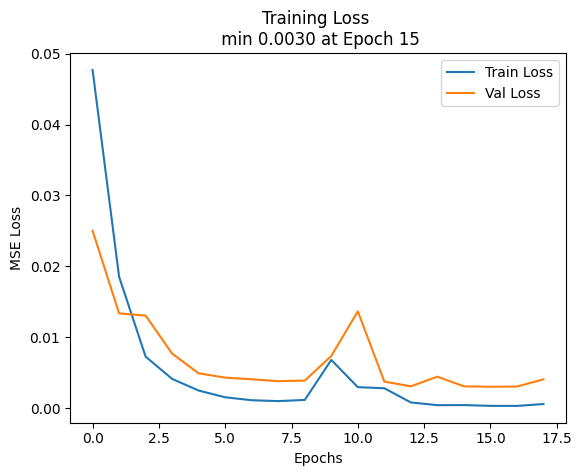

In [4]:
# Initialize the model
model1 = Sequential()
print(type(model1))  # <class 'keras.engine.sequential.Sequential'>

# Input layer
model1.add(Input(shape=(100, 100, 1)))  # Grayscale image input of size 100x100

# Convolutional and pooling layers
model1.add(Conv2D(8, (3, 3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(16, (5, 5)))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten before Dense layers
model1.add(Flatten())

# Fully connected layers
model1.add(Dense(500,activation="gelu"))

model1.add(Dense(240,activation="gelu"))

model1.add(Dense(120,activation="gelu"))

model1.add(Dense(60,activation="gelu"))

model1.add(Dense(30,activation="gelu"))

model1.add(Dense(15,activation="gelu"))


# Output layer for binary classification
model1.add(Dense(1, activation="sigmoid"))

model1.compile(optimizer='adam',
               loss='mse',
               metrics=['mae'])



#======Training=======
# === Early Stopping Callback  ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-3,
    restore_best_weights=True,
    verbose=1
)

history = model1.fit(X_train, y_train, epochs=100, 
                     validation_data=(X_test, y_test),
                     callbacks=[early_stop], 
                     batch_size=32, 
                     verbose=1)



# === Plot Training ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

min_val_loss = min(val_loss)
min_val_epoch = val_loss.index(min_val_loss)

# Plot the losses
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title(f'Training Loss \n min {min_val_loss:.4f} at Epoch {min_val_epoch}')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [5]:
model1.save("BFP02D2x4s40N2T035.h5")

C:\Users\12345\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
